This Notebook gives an introduction for dealing with multiple annotators using `scikit-activeml`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from skactiveml.classifier import PWC
from skactiveml.pool import UncertaintySampling
from skactiveml.pool.multi._wrapper import MultiAnnotWrapper
from skactiveml.pool.multi.multi_annot_visualisation import plot_current_state
from skactiveml.utils import is_unlabeled

Suppose we have the following problem. We have 100 samples having 2 features
belonging to either one of two classes.

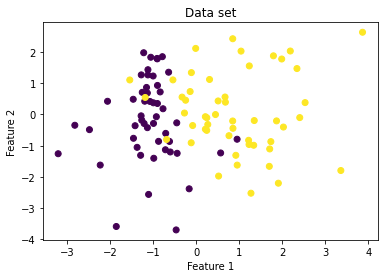

In [3]:
n_samples = 100
X, y_true = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y_true)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data set');

Further, suppose we have 5 annotators to label the samples. The annotators have
different accuracies for labeling the samples.

In [4]:
n_annotators = 5
y_annot = np.zeros(shape=(n_samples, n_annotators), dtype=int)
for i, p in enumerate(np.linspace(0.0, 0.5, num=n_annotators)):
    y_noise = np.random.binomial(1, p, n_samples)
    y_annot[:, i] = y_noise ^ y_true

We want to label these samples using a Parzen window classifier. We query the
samples using uncertainty sampling, and the annotators at random using the
`MultiAnnotWrapper`.


In [5]:
clf = PWC(classes=np.unique(y_true))
sa_qs = UncertaintySampling(clf=clf, method='entropy')
ma_qs = MultiAnnotWrapper(sa_qs, random_state=0, n_annotators=n_annotators)

We loop through the process of querying an annotator, and a sample each iteration.

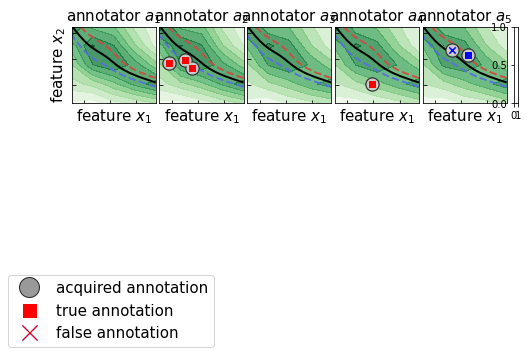

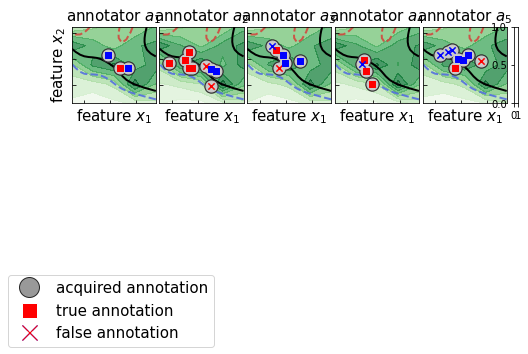

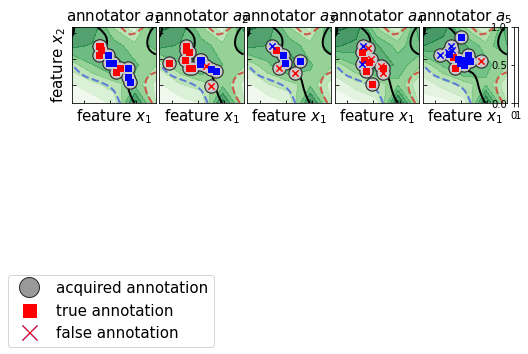

In [11]:
idx = lambda A: (A[:, 0], A[:, 1])

n_cycle = 20
y = np.full(shape=(n_samples, n_annotators), fill_value=np.nan)
for c in range(n_cycle):
    A_cand = is_unlabeled(y)
    query_idx = ma_qs.query(X_cand=X, X=X, y=y, A_cand=A_cand,
                            batch_size=3, pref_annotators_per_sample=1)

    y[idx(query_idx)] = y_annot[idx(query_idx)]

    clf.fit(X, y)
    if c in [1, 9, 19]:
        plot_current_state(X, y, y_true, ma_qs, clf)